#### CGM Data

Now, we dive into the glucose monitored data. These are taken by a CGMS (Continuous Glucose Monitoring system) such as iPro developed by Medtronic MiniMed, Northridge, CA, USA.

Let's import one of the users raw CGM data so we can have a look.

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

<span style='background:yellow'> changer nombre de patients diabétiques</span>

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from download_data import read_raw_clinical_data

X = read_raw_clinical_data(path='../')
y = X["T2DM"].values

print(f"Number of DT2 diagnosed patients: {str(y.sum())}/{len(y)}")
print(f"Proportion of DT2 diagnosed patients: {str(y.sum()/len(y) * 100)[0]}/{100}")

Number of DT2 diagnosed patients: 17/208
Proportion of DT2 diagnosed patients: 8/100


<span style='background:yellow'> end modif </span>

<AxesSubplot:>

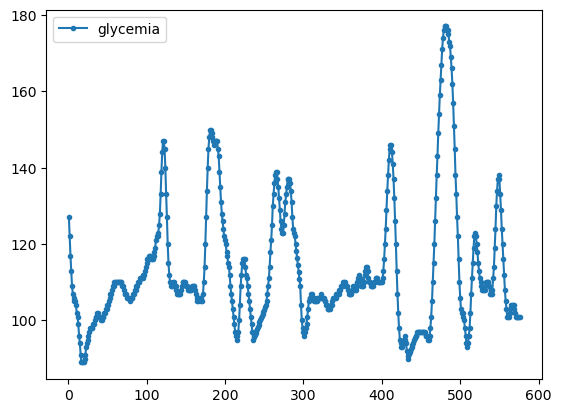

In [3]:
from download_data import get_cgm_data as get_raw_cgm_data

raw_cgm_data = get_raw_cgm_data(6, path='../')
raw_cgm_data.plot(marker='.', linestyle='-')

##### Interpolation of the Continuous Glucose values

As we can see on the previous curve, we might have some situations in which the CGM is not capturing the blood sugar value for various reasons (disconnection, high pressure on the measurement area, out of measurement area, ...).

Interpolation is a method widely used to estimate missing CGM data by predicting values that would have been recorded if the sensor had not failed (see https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3692219/).

There are several methods for interpolation of missing CGM data, but the choice of method depends on the nature of the data and the goals of the analysis. For our application, we use the Linear interpolation method that has been accepted by the medical community through multiple grid systems (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2903980/). This method estimates missing values by connecting the neighboring observed values with a straight line. It assumes that the glucose values change linearly over time, which is also widely verified by short term linear forecasting of blood glucose models that are able to achieve impressive accuracy (15 minutes being a short range for instance).

Some other commonly used interpolation methods are:

- The cubic spline interpolation: This method estimates missing values by fitting a smooth curve to the observed data using cubic polynomials. Cubic spline interpolation assumes that the glucose values change smoothly over time.

- The Kalman filter: This method estimates missing values by using a mathematical model that predicts the glucose values based on the observed data and the known properties of the system. Kalman filter interpolation assumes that the glucose values follow a stochastic process. This method has been widely in used recently to interpolate Glucose data.

<AxesSubplot:>

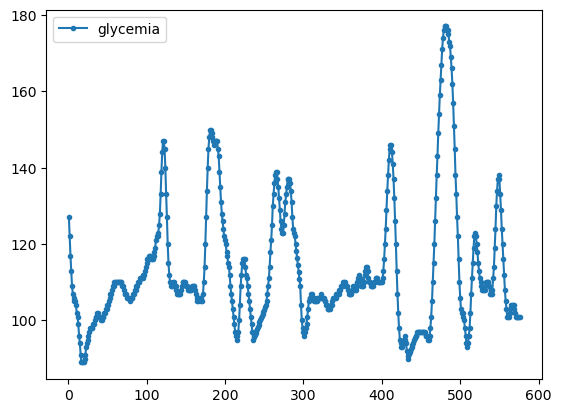

In [4]:
cgm_data_interp = raw_cgm_data.interpolate(method="linear")
cgm_data_interp.plot(marker='.', linestyle='-')

##### Statistics and feature extraction on the CGM data

The interpolation is preprocessed when running the `download_data.py` script that generates the `external_data.csv` file, which contains preprocessed CGM time series of each person in the dataset.

These time series are either of length 48h or 24h, depending on how long the sensor was attached to the patient. For simpler data management, the `external_data.csv` contains the dataframe of the time series of with `NaN` values after 24h length if no data is recorded.

<AxesSubplot:>

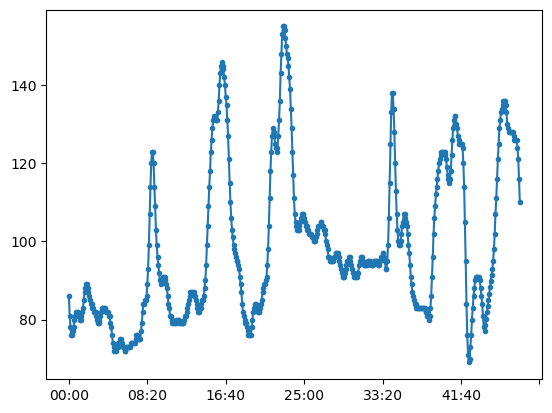

In [5]:
def get_cgm_data(path='../'):
    data = pd.read_csv(path+'external_data.csv')
    data.set_index('patient_id', inplace=True)
    return data

def get_patient_cgm_data(patient_id, path='../'):
    cgm_data = get_cgm_data(path)
    patient_cgm = cgm_data.loc[patient_id]
    patient_cgm.dropna(inplace=True)
    return patient_cgm

cgm_data = get_patient_cgm_data(1)
cgm_data.plot(label='glycemia', marker='.')

Let's count how many of these time series are only 24h long, and see to which individual they belong to.

In [6]:
all_cgm_data = get_cgm_data()
nan_cgm_rows = all_cgm_data[all_cgm_data.isna().any(axis=1)]

print(f'Number of 24h long time series: {len(nan_cgm_rows)}/{len(all_cgm_data)}')

nan_entries_diabetics = y[nan_cgm_rows.index - 1]

print(f'Number of diabetics among these: {nan_entries_diabetics.sum()}/{len(nan_entries_diabetics)}')

Number of 24h long time series: 17/208
Number of diabetics among these: 0/17


Let's try making some interesting statistics on these time series, so we can extract relevant features that characterizes well diabetics.

<AxesSubplot:xlabel='label', ylabel='cgm_max'>

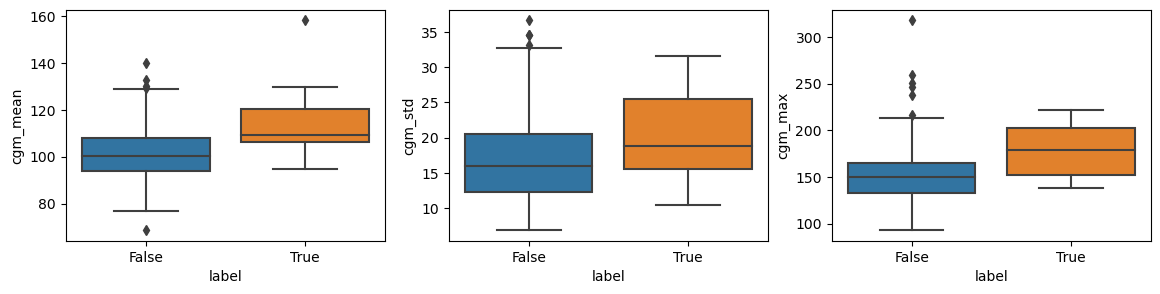

In [7]:
stats = pd.DataFrame(index=all_cgm_data.index)

stats["label"] = y[all_cgm_data.index - 1]
stats["cgm_mean"] = list(all_cgm_data.mean(axis=1))
stats["cgm_max"] = list(all_cgm_data.max(axis=1))
stats["cgm_std"] = list(all_cgm_data.std(axis=1))

plt.figure(figsize=(14,3))
plt.subplot(1,3,1)
sns.boxplot(data=stats, x='label', y="cgm_mean")
plt.subplot(1,3,2)
sns.boxplot(data=stats, x='label', y="cgm_std")
plt.subplot(1,3,3)
sns.boxplot(data=stats, x='label', y="cgm_max")

We can see that descriptive statistics of the CGM time series could be use for differenciation between diabetic and non diabetic patients. Diabetic patients tend to have a higher mean of glucose value during the day, and reach higher maximum than non diabetic people, being a symptom of the disease.

We can implement a large variety of metrics to analyse this CGM data. It could be interesting to understand the time spent by patients in hyperglycemia or normal range, as a percentage of a day for example. The following functions allow to consider the proportion of the day spent by the patient in the normal interval glycemia and above.

<AxesSubplot:xlabel='label', ylabel='time_in_hyperglycemia'>

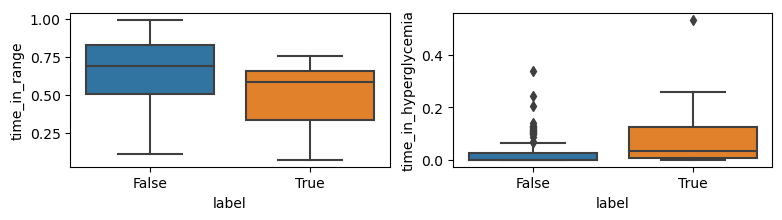

In [8]:
def compute_average_time_in_range(cgm_val, normal_range=[70, 110]):
    col_in_range = cgm_val[(cgm_val >= normal_range[0]) & (cgm_val <= normal_range[1])]
    return len(col_in_range)/len(cgm_val)

def compute_average_time_above(cgm_val, value=150):
    col_above = cgm_val[(cgm_val > value)]
    return len(col_above)/len(cgm_val)

stats["time_in_range"] = all_cgm_data.apply(compute_average_time_in_range, axis=1)
stats["time_in_hyperglycemia"] = all_cgm_data.apply(compute_average_time_above, axis=1)

plt.figure(figsize=(14,2))
plt.subplot(1,3,1)
sns.boxplot(data=stats, x='label', y="time_in_range")
plt.subplot(1,3,2)
sns.boxplot(data=stats, x='label', y="time_in_hyperglycemia")

<span style='background:yellow'> debut modif </span>

We can also compute other features on CGM time series, such as the area under the CGM curve on 24h, the skewness, or different percentiles (here 3rd quartile).

**NB :** We need to normalize these features such as their meaning and interpretation are the same if the patient has 24h or 48h of CGM data. For mean, variance, skewness or proportion above a certain glucose value for example, there is no need to post-process the value as they are already comparable for different length of series. However, for the area under the cgm curve for example, we need to find a way such that the series of 24h, dividing by the number of points or multiply the areas for 24h by 2 for the corresponding patients. 

We also need to be careful with computations of those features with missing values : some functions may return Nan that we want to avoid.

In [9]:
from numpy import trapz
def area_norm_points(cgm_val):
    if cgm_val.isna().sum() !=0:
        area = trapz(cgm_val[:288])/288
    else:
        area = trapz(cgm_val)/576
    return area

def area_norm_48h(cgm_val):
    if cgm_val.isna().sum() !=0:
        area = trapz(cgm_val[:288])*2
    else:
        area = trapz(cgm_val)
    return area

<AxesSubplot:xlabel='area_under_cgm_norm_points', ylabel='area_under_cgm_norm_48h'>

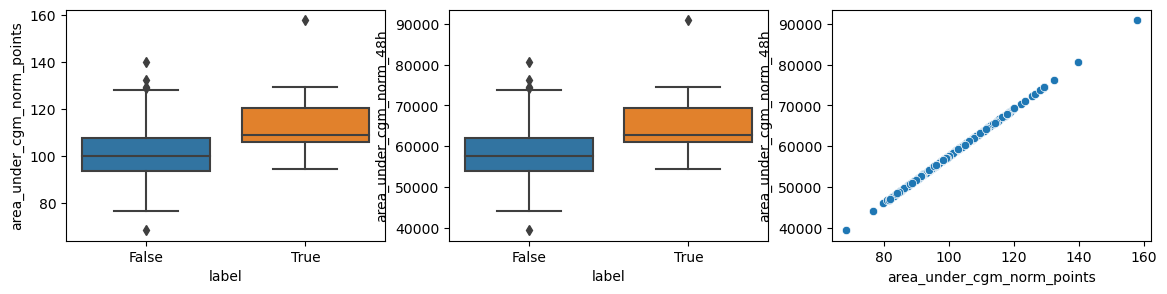

In [10]:
stats["area_under_cgm_norm_points"] = all_cgm_data.apply(area_norm_points, axis=1)
stats["area_under_cgm_norm_48h"] = all_cgm_data.apply(area_norm_48h, axis=1)

plt.figure(figsize=(14,3))
plt.subplot(1,3,1)
sns.boxplot(data=stats, x='label', y="area_under_cgm_norm_points")
plt.subplot(1,3,2)
sns.boxplot(data=stats, x='label', y="area_under_cgm_norm_48h")
plt.subplot(1,3,3)
sns.scatterplot(data=stats, x='area_under_cgm_norm_points', y="area_under_cgm_norm_48h")

As we can see, the two normalisation approaches for area under CGM curve are completely equivalent. Patients with Type 2 diabetes may have a higher area under their CGM curve, probably because they are more subject to high values of glucose (hyperglycemia) and maybe more variability than healthy patients.

We can also study other statistics of the series : quantiles or asymmetry of the distribution for example (skewness).
According to the graphs, skewness (asymmetry of CGM distribution) does not seem to be an important feature for Type 2 diabetic and non diabetic patients distinction. The first and third quartile seem to be higher in the glucose measurements time series for Type 2 diabetic patients, which confirm the results obtained until now on potential hyperglycaemia higher for T2 diabetic pateints.

In [11]:
stats["skewness"] = list(all_cgm_data.skew(axis=1))
stats["Q1"] = list(all_cgm_data.quantile(0.25, axis=1))
stats["Q3"] = list(all_cgm_data.quantile(0.75, axis=1))

<AxesSubplot:xlabel='label', ylabel='Q3'>

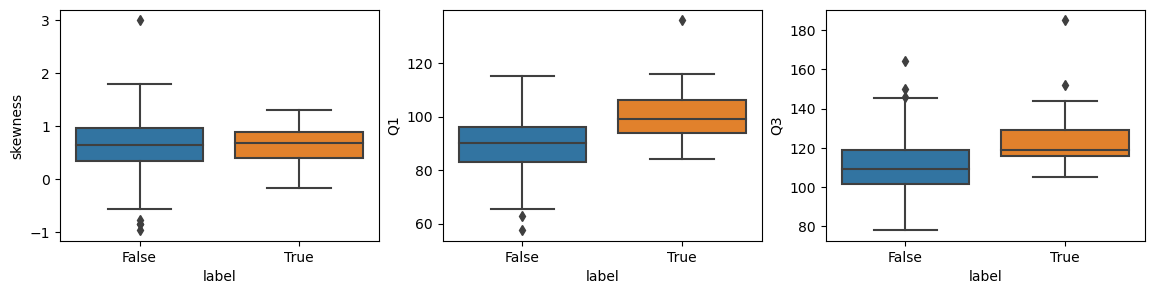

In [12]:
plt.figure(figsize=(14,3))
plt.subplot(1,3,1)
sns.boxplot(data=stats, x='label', y="skewness")
plt.subplot(1,3,2)
sns.boxplot(data=stats, x='label', y="Q1")
plt.subplot(1,3,3)
sns.boxplot(data=stats, x='label', y="Q3")

In [13]:
stats.isna().sum()

label                         0
cgm_mean                      0
cgm_max                       0
cgm_std                       0
time_in_range                 0
time_in_hyperglycemia         0
area_under_cgm_norm_points    0
area_under_cgm_norm_48h       0
skewness                      0
Q1                            0
Q3                            0
dtype: int64

The article also mentions entropy measures : Approximate (ApEn) and Sample (SampEn) entropies, that can be computed creating new functions, such as the example below found on https://en.wikipedia.org/wiki/Sample_entropy (Warning : the computation time can be long).

Entropy metrics assess the predictability of the time series : how the preceding points determine the following ones. A high sample entropy implies less predictability accross the series, and thus a higher complexity (possibly linked to Type 2 diabetes for glucose measurements). This pattern is not really clear on our data, but this feature could be useful to consider in a machine learning model in combination with others.

In [14]:
def sampen(L, m=2, r=3):
    """Sample entropy."""
    N = len(L)
    B = 0.0
    A = 0.0
    # Split time series and save all templates of length m
    xmi = np.array([L[i : i + m] for i in range(N - m)])
    xmj = np.array([L[i : i + m] for i in range(N - m + 1)])
    # Save all matches minus the self-match, compute B
    B = np.sum([np.sum(np.abs(xmii - xmj).max(axis=1) <= r) - 1 for xmii in xmi])
    # Similar for computing A
    m += 1
    xm = np.array([L[i : i + m] for i in range(N - m + 1)])
    A = np.sum([np.sum(np.abs(xmi - xm).max(axis=1) <= r) - 1 for xmi in xm])
    # Return SampEn
    return -np.log(A / B)

In [15]:
stats["SampEn"] = list(all_cgm_data.apply(sampen, axis=1))

<AxesSubplot:xlabel='label', ylabel='SampEn'>

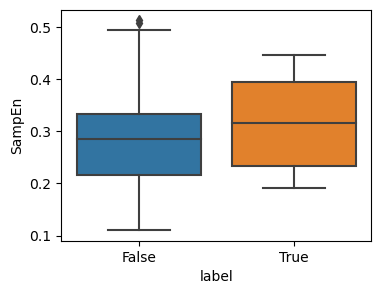

In [16]:
plt.figure(figsize=(4,3))
sns.boxplot(data=stats, x='label', y="SampEn")

Finally, another type of metrics considered in the paper are the ones derived from the Poincaré plot. 

Poincaré plot assign each point on the x-axis to the following point in the series on the y-axis. The obtained cloud of points is then fitted to an ellipse, from which we can derive the standard deviation with respect to the horizontal axis of the fitted ellipse (SD1), and the vertical one (SD2). (Henriques et al., 2014 : “Glucose-at-a-Glance”: New Method to Visualize the Dynamics of Continuous Glucose Monitoring Data, https://journals.sagepub.com/doi/10.1177/1932296814524095).
We can consider only 24 hours of data for each patient for these features to be consistent, or find a normalisation way to consider time series of 24 and 48 hours as detailed before.


In [17]:
from matplotlib.patches import Ellipse
def plot_poincare(cgm_data, plot=False):
    cgm_data_n = np.array(cgm_data[:-1])
    cgm_data_n1 = np.array(cgm_data[1:])

    sd1 = np.sqrt(0.5) * np.std(cgm_data_n1 - cgm_data_n)
    sd2 = np.sqrt(0.5) * np.std(cgm_data_n1 + cgm_data_n)

    if plot == True:
        m = np.mean(cgm_data_n)
        min_cgm = np.min(cgm_data_n)
        max_cgm = np.max(cgm_data_n)
        
        plt.figure(figsize=(5, 5))
        plt.title("Poincare plot")
        sns.scatterplot(x=cgm_data_n, y=cgm_data_n1, color="#51A6D8")

        plt.xlabel(r'$glucose_n (mg/dL)$')
        plt.ylabel(r'$glucose_{n+1} (mg/dL)$')

        e1 = Ellipse((m, m), 2*sd1, 2*sd2, angle=-45, linewidth=1.2, fill=False, color="k")
        plt.gca().add_patch(e1)

        plt.arrow(m, m, (max_cgm-min_cgm)*0.4, (max_cgm-min_cgm)*0.4, color="k", head_length=2, head_width=2)
        plt.arrow(m, m, (min_cgm-max_cgm)*0.4, (max_cgm-min_cgm)*0.4, color="k", head_width=2, head_length=2)

        plt.arrow(m, m, sd2 * np.sqrt(0.5), sd2 * np.sqrt(0.5), color="green", linewidth=1, label="SD2")
        plt.arrow(m, m, -sd1 * np.sqrt(0.5), sd1 * np.sqrt(0.5), color="red", linewidth=1, label="SD1")
        plt.legend()
    
    return sd1, sd2

In [21]:
def sd1(cgm_val):
    # consider only 24 hours of data for each patient
    cgm_val = cgm_val[:288]
    cgm_data_n = np.array(cgm_val[:-1])
    cgm_data_n1 = np.array(cgm_val[1:])

    sd1 = np.sqrt(0.5) * np.std(cgm_data_n1 - cgm_data_n)
    return sd1

def sd2(cgm_val):
    # consider only 24 hours of data for each patient
    cgm_val = cgm_val[:288]
    cgm_data_n = np.array(cgm_val[:-1])
    cgm_data_n1 = np.array(cgm_val[1:])

    sd2 = np.sqrt(0.5) * np.std(cgm_data_n1 + cgm_data_n)
    return sd2

SD1: 1.705 ms
SD2: 27.710 ms


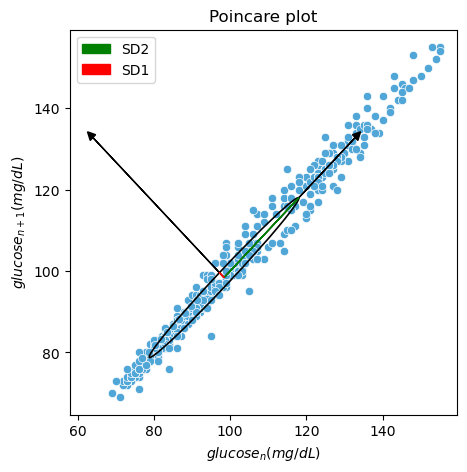

In [19]:
sd1, sd2 = plot_poincare(all_cgm_data.loc[1,:], plot=True)
print("SD1: %.3f ms" % sd1)
print("SD2: %.3f ms" % sd2)

In [22]:
stats["SD1"] = list(all_cgm_data.apply(sd1, axis=1))
stats["SD2"] = list(all_cgm_data.apply(sd2, axis=1))
stats["ellipse_quot"] = stats["SD1"]/stats["SD2"]

<AxesSubplot:xlabel='label', ylabel='ellipse_quot'>

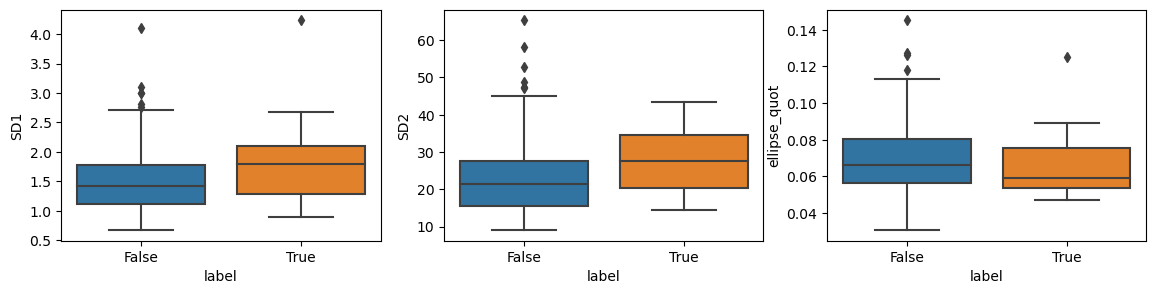

In [ ]:
plt.figure(figsize=(14,3))
plt.subplot(1,3,1)
sns.boxplot(data=stats, x='label', y="SD1")
plt.subplot(1,3,2)
sns.boxplot(data=stats, x='label', y="SD2")
plt.subplot(1,3,3)
sns.boxplot(data=stats, x='label', y="ellipse_quot")

In our data, these features seem to be not key factors to differentiate Type 2 diabetic from non diabetic patients. It can be possible that the predictability of a glucose value according to the previous ones is not discriminating patients according to the presence of diabetes or not.

<span style='background:yellow'> fin modif </span>

So we can compute these features in our pipeline, we would put them into a wrapper of functions in our notebook. In practice, these functions are implemented in the `estimator.py` within the `FeatureExtractor`.

In [27]:
def compute_variance(cgm_data):
    return cgm_data.var()

def compute_mean(cgm_data):
    return cgm_data.mean()

def compute_average_time_in_range(cgm_data, normal_range=[70, 127]):
    index_in_range = cgm_data[(cgm_data >= 70) & (cgm_data <= 127)].index
    return len(index_in_range)/len(cgm_data.index)

def compute_maximum(cgm_data):
    return cgm_data.max()

additional_features = {
    "CGM Variance":compute_variance,
    "CGM Mean": compute_mean,
    "CGM Time in range": compute_average_time_in_range,
    "CGM Maximum": compute_maximum,
}

print("Extracted features:")
for name, fun in additional_features.items():
    print(f'  * {name}: {fun(cgm_data)}')

Extracted features:
  * CGM Variance: 385.6137850241557
  * CGM Mean: 98.42013888888889
  * CGM Time in range: 0.8802083333333334
  * CGM Maximum: 155.0


These new features regarding the patients are part of the data exploration we can do on the CGM time series, to finally determine whether the patient is going to be DT2 or not in addition to the clinical data.

Other suggestions could be implemented: looking at postprandial overall values (that would use more of the time serie structure), night mean value, day mean value, day variance, slide the time series in windows, etc...

<span style='background:yellow'> supprimer ici ? </span>

#### Some statistical insights on the CGM data

One can import all the CGM data (48h sampled) using the following code snippet (be careful with NaNs)

In [28]:
cgm_48h = get_cgm_data()
cgm_48h.head()

,00:00,00:05,00:10,00:15,00:20,00:25,00:30,00:35,00:40,00:45,...,47:10,47:15,47:20,47:25,47:30,47:35,47:40,47:45,47:50,47:55
patient_id,,,,,,,,,,,,,,,,,,,,,
1,86.0,81.0,78.0,76.0,76.0,77.0,78.0,80.0,81.0,82.0,...,128.0,127.0,126.0,126.0,126.0,126.0,124.0,121.0,116.0,110.0
2,167.0,163.0,158.0,151.0,144.0,137.0,132.0,127.0,125.0,125.0,...,129.0,129.0,129.0,129.0,129.0,130.0,130.0,131.0,132.0,133.0
3,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,89.0,88.0,...,89.0,90.0,90.0,92.0,93.0,94.0,95.0,96.0,96.0,97.0
4,93.0,92.0,92.0,91.0,92.0,93.0,95.0,98.0,101.0,103.0,...,124.0,122.0,120.0,119.0,119.0,118.0,117.0,115.0,113.0,111.0
5,107.0,109.0,111.0,114.0,116.0,116.0,116.0,115.0,113.0,110.0,...,120.0,121.0,124.0,128.0,131.0,134.0,136.0,137.0,136.0,134.0


## Building predictive models

First we fetch the training and testing sets

In [29]:
from problem import get_train_data, get_test_data

X_train, y_train = get_train_data()
X_test, y_test = get_test_data()

For submitting to the [RAMP site](https://ramp.studio), you will need to create a `estimator.py` file that defines a `get_estimator` function which returns a scikit-learn estimator.

The initial example classifier in your sandbox is:

In [30]:
import sklearn.preprocessing as preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Functions to fetch the CGM data and plug new features in the dataset taken from the series
def get_cgm_data():
    data = pd.read_csv('external_data.csv')
    data.set_index('patient_id', inplace=True)
    return data

def get_patient_cgm_data(patient_id):
    cgm_data = get_cgm_data()
    patient_cgm = cgm_data.loc[patient_id]
    patient_cgm.dropna(inplace=True)
    return patient_cgm

def add_cgm_feature(clinical_data, feature_name, compute_feature_function):
    n_individuals = len(clinical_data)
    feature_column = np.zeros((n_individuals,))

    for i, user_id in enumerate(clinical_data.index.values):
        cgm_data = get_patient_cgm_data(int(user_id))
        feature = compute_feature_function(cgm_data)
        feature_column[i] = feature

    clinical_data[feature_name] = feature_column
    return clinical_data

# Wrapper for the feature extraction
class FeatureExtractor:
    
    def __init__(self):
        pass
    
    def fit(self, X, y):
        return self
    
    def transform(self, X):
        for name, fun in additional_features.items():
            X = add_cgm_feature(X, name, fun)
        return X

# Minimal preprocessing of the data
def get_preprocessing():
    return preprocessing.StandardScaler(), preprocessing.MinMaxScaler()
            
def get_estimator():
    
    feature_extractor = FeatureExtractor()
    
    classifier = RandomForestClassifier(
        n_estimators=50, random_state=61
    )
    
    pipe = make_pipeline(
        feature_extractor,
        *get_preprocessing(),
        classifier
    )
    
    return pipe

In [31]:
feature_extractor = FeatureExtractor()
feature_extractor.transform(X_train)

,gender,age,BMI,glycaemia,CGM Variance,CGM Mean,CGM Time in range,CGM Maximum
patient_id,,,,,,,,
57,1.0,62.0,34.9,84.0,202.075314,98.090278,0.961806,153.0
201,0.0,70.0,27.9,111.0,58.625868,105.279514,0.993056,128.0
56,0.0,46.0,41.1,120.0,152.851196,112.364583,0.887153,152.0
76,0.0,38.0,34.0,98.0,279.174538,101.432292,0.907986,153.0
19,1.0,59.0,32.2,89.0,174.381894,93.698785,0.961806,131.0
...,...,...,...,...,...,...,...,...
67,0.0,58.0,27.0,114.0,124.931002,94.892361,0.998264,128.0
177,0.0,48.0,31.8,97.0,542.006908,111.006944,0.809028,172.0
113,0.0,67.0,27.0,96.0,480.467198,98.423611,0.873264,163.0


When developing locally, you can use `scikit-learn` tools to test a given model.

In [32]:
from sklearn.model_selection import cross_val_score
from problem import get_cv

cv = get_cv(X_train, y_train)
cross_val_score(get_estimator(), X_train, y_train, cv=cv)

array([0.92857143, 0.92857143, 0.92857143, 0.89285714, 0.92592593,
       0.92857143, 0.92857143, 0.89285714, 0.89285714, 0.92592593,
       0.89285714, 0.92857143, 0.92857143, 0.89285714, 0.92592593])

You could easily train an test a model and the respective datasets.

In [33]:
model = get_estimator()
model.fit(X_train, y_train)

y_true = y_test
y_pred = model.predict(X_test)

In [34]:
import sklearn.metrics as metrics

metrics_list = {
    "Balanced Accuracy":metrics.balanced_accuracy_score, 
    "F1":metrics.f1_score, 
    "Precision":metrics.precision_score, 
    "Recall":metrics.recall_score
}

for name, metric in metrics_list.items():
    print(f"* {name}: {metric(y_true, y_pred)}")

print("Confusion matrix")
metrics.confusion_matrix(y_true, y_pred)

* Balanced Accuracy: 0.5753968253968254
* F1: 0.25
* Precision: 0.5
* Recall: 0.16666666666666666
Confusion matrix


array([[62,  1],
       [ 5,  1]], dtype=int64)

In [35]:
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


# Submission

To submit your code, you can refer to the [online documentation](https://paris-saclay-cds.github.io/ramp-docs/ramp-workflow/stable/using_kits.html)